## Wikipeda web scraper 

Scrape data from wikipedia <br />
Clean data <br />
Winner's time progression chart <br />
Lanes of OI medalists (since 1984) <br />
Nation of OI medalists <br />
Lanes of OI winners (since 1984) <br />
Nation of OI winners <br />

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import Counter
import matplotlib.gridspec as gridspec
import math

# list of results per year
#dfList = []

# list of olympic years
#years = []

# OI 1904 measure was yard, instead of metre 
#measure = []

startUrl = "https://en.wikipedia.org/wiki/Swimming_at_the_2020_Summer_Olympics"

# starting url. OI 2020
#currentUrl = "https://en.wikipedia.org/wiki/Swimming_at_the_2020_Summer_Olympics_%E2%80%93_Men%27s_800_metre_freestyle"

#nationMedalists = []
#nationWinners = []

#medalNationNames = []
#medalNationMedals= []

#winnerNationNames = []
#winnerNationMedals= []

#laneWinners=[]

#laneMedals=[]

#winnerTimes= []

In [2]:
def getLinks(startUrl):
    links = []
    soup = getSoup(startUrl)
    table  = soup.find(class_="sidebar-games-events sidebar nomobile")
    linkElements = table.findAll('a')
    for element in linkElements:
        link = element.get('href')
        if link: 
            if "freestyle" in link and "relay" not in link:
                link = "https://en.wikipedia.org"+link
                links.append(link)
    return links
# parse current page
def getSoup(urlWiki):
    response = requests.get(
        url=urlWiki,
    )
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

#metre  or yard
def getMeasure(soup):
    titleHeader = soup.find(id="firstHeading")
    title = titleHeader.string
    metre = "metre" in title
    return metre

#get year
def getYear(soup):
    titleHeader = soup.find(id="firstHeading")
    title = titleHeader.string
    yearMatch  = re.search(r'[12]\d{3}', title)
    yearStr = yearMatch.group(0)
    return yearStr

def getRace(soup):
    titleHeader = soup.find(id="firstHeading")
    title = titleHeader.string
    race = title.split("–",1)[1]
    return race
    
# get "Final" table
def getTable(soup):
    
    final = soup.find(id="Final" )

    if final:     
        header= final.parent
        resultsTable=header.findNext('table') 
        final2 = soup.find(id="Final_2")

        if final2:
            header= final2.parent
            resultsTable=header.findNext('table')   
       
            
    else:
        final = soup.find(id="Final_A")
        if final:
            header= final.parent
            resultsTable=header.findNext('table')
        else:
            final = soup.find(id="Results")
            header= final.parent
            resultsTable=header.findNext('table')
    
    return resultsTable

#convert time to seconds
def convertToSeconds(x):
    x = x.split(":")
    if len(x) == 2:
        return float(x[0]) * 60 + float(x[1])
    return float(x[0]) * 3600 + float(x[1]) * 60 + float(x[2])

# medals have images instead of numbers
# there is not always exactly 1g 1s 1b medal
def getMedals(resultsTable, position):
    medals = 0
    place = "1st"
    medal="gold"
    
    if position == 2:
        place = "2nd"
        medal = "silver"
    elif position == 3:
        place = "3rd"
        medal = "bronze"
        
    medalTags = resultsTable.find_all("img", {"alt": place+" place, "+medal+" medalist(s)"})
    if medalTags:
        for tag in medalTags:
            medals+=1
    else:
        medalTags = resultsTable.find_all("img", {"alt": position})
        for tag in medalTags:
            medals+=1
    return medals

# convert final results to data frame
def createDataFrame(resultsTable, goldMedals, silverMedals, bronzeMedals):
    
    df=pd.read_html(str(resultsTable))
    # convert list to dataframe
    df=pd.DataFrame(df[0])
    
    header = list(df.columns.values)
    if type(header[0]) is tuple:
        df=pd.read_html(str(resultsTable), header=1)

        df=pd.DataFrame(df[0])
    

 # replace nulls with appropriate medals   
    for i in range(goldMedals):
        df["Rank"] = df["Rank"].fillna(1, limit=1)
        goldMedals-=1
        
    for i in range(silverMedals):
        df["Rank"] = df["Rank"].fillna(2, limit=1)
        silverMedals-=1
        
    for i in range(bronzeMedals):
        df["Rank"] = df["Rank"].fillna(3, limit=1)
        bronzeMedals-=1
    #change rank type to integer CLEANING
    #df = df.astype({'Rank':'int'})
    
    return df    

def getMedalNations(df,medals):
    nations = []
    for i in range(medals):
        nations.append(df["Nation"].iat[i])
    return nations

def getMedalLanes(df,medals):
    lanes = []
    for i in range(medals):
        lanes.append(df["Lane"].iat[i])
    return lanes

def renameColumns(df):   
    #replacing DSQ with 0
    #df["Rank"] = df["Rank"].replace("—",0)    
    #df = df[df.Rank!= "3–10"]
    df.rename(columns = {'Time (2nd)':'Time'}, inplace = True)
    df.rename(columns = {'Second race':'Time'}, inplace = True)
    df.rename(columns = {'Name':'Swimmer'}, inplace = True)
    df.rename(columns = {'Nationality':'Nation'}, inplace = True)
    df.rename(columns = {'Country':'Nation'}, inplace = True)
    df.rename(columns = {'Place':'Rank'}, inplace = True)
    df = df[df.Time != "DNS"]
    df = df[df.Time != "DSQ"]    
    df = df[df.Time != "DNF"]
    df = df[df.Rank != "3–10"]
    df = df[df.Time != "—"]

    return df

def setRanks(df):
    counter = 0
    rankList = df.Rank.values.tolist()
    
    for i in range(len(rankList)):
        rankList[i] = float(rankList[i])
        if math.isnan(rankList[i]):
            rankList[i]=rankList[i-1]
            rankList[i-1]=rankList[i-2]
            if rankList[i-1]<5: counter+=1

    df["Rank"]=rankList
    
    return  df, counter

def cleanData(df):  
    df = df[df.Time != "Unknown"]
    #df = df[df.Time != "—"]
    #df = df[df.Time != "DNS"]
    #df = df[df.Time != "DSQ"]

    #df = pd.to_datetime(df['Time'], format="%H:%M:%S")
    df = df.astype({'Rank':'int'})
    df = df.astype({'Time':'str'})
    
    df['Time'] = '0:' + df['Time'].astype(str)
    df["Time"] = df["Time"].apply(convertToSeconds)
   
    return df


# go to the previous OI
def getPrevious(soup):
    urlNew=""
    previous=soup.find(class_="infobox-below noprint nowrap")
    if previous:
    
        children = previous.find_all("a")

        # for 1896 OI there are no previous OI, just the next one. When there are no new OI 
        if len(children)==2:
            if "%" in children[0]['href']:
                urlNew="https://en.wikipedia.org"+ children[0]['href']
            
    return urlNew

def countDistinctNation(nations):
    nationsCount = (word for word in nations if word[:1].isupper())
    Count = Counter(nationsCount)
    distinctNations = Count.most_common(5)
    return distinctNations

In [3]:

def plotResults(currentUrl):
    # list of results per year
    dfList = []

    # list of olympic years
    years = []

    # OI 1904 measure was yard, instead of metre 
    measure = []

    nationMedalists = []
    nationWinners = []

    medalNationNames = []
    medalNationMedals= []

    winnerNationNames = []
    winnerNationMedals= []

    laneWinners=[]

    laneMedals=[]

    winnerTimes= []
    race = ""

    #get the results
    while currentUrl !="": 

        soup = getSoup(currentUrl)

        year = getYear(soup)

        metre = getMeasure(soup)
        if race == "":
            race = getRace(soup)
        
        if metre!=True: year = year+" *"
        measure.append(metre)
        years.append(year)
        resultsTable = getTable(soup)

        goldMedals = getMedals(resultsTable, 1)
        silverMedals = getMedals(resultsTable, 2)
        bronzeMedals = getMedals(resultsTable, 3)

        df = createDataFrame(resultsTable, goldMedals, silverMedals, bronzeMedals)
        df = renameColumns(df)
        #print(df.head(10))
        fillRanks = setRanks(df)
        df = fillRanks[0]
        totalMedals = goldMedals + silverMedals + bronzeMedals+fillRanks[1]

        #print(totalMedals)
        nations = getMedalNations(df,totalMedals)
        nationMedalists.extend(nations)
        nationWinners.append(df["Nation"].iat[0])

        if "Lane" in df:
            lanes = getMedalLanes(df,totalMedals)
            laneMedals.extend(lanes)
            laneWinners.append(df["Lane"].iat[0])

        df = cleanData(df) 

        winnerTime = df["Time"].iat[0]
        winnerTimes.append(winnerTime)

        dfList.append(df)
        currentUrl= getPrevious(soup)

    #race = getRace(soup)
    years.reverse()    
    winnerTimes.reverse()

    laneWinnerCount = Counter(laneWinners)
    laneMedalsCount = Counter(laneMedals)

    #for df in dfList:
        #print(df.head(10))
        #result = df.dtypes
        #print(result)

    medalNations = countDistinctNation(nationMedalists)
    medalNationNames = [x[0] for x in medalNations]
    medalNationMedals = [x[1] for x in medalNations]

    winnerNations = countDistinctNation(nationWinners)
    winnerNationNames = [x[0] for x in winnerNations]
    winnerNationMedals = [x[1] for x in winnerNations]
    plt.rcParams['figure.figsize'] = [30, 20]
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(3, 2, wspace=0.05)# remove if not necessary, wspace=0.1, hspace=0.1)

    ax = fig.add_subplot(gs[0, :])
    ax.plot(years,winnerTimes)
    counter=0
    for i in range(len(years)):

        if "*" in years[i]:
            ax.plot(years[i], winnerTimes[i], 'r*', label="yards")
        elif counter == 0:    
            ax.plot(years[i], winnerTimes[i], 'bo', label="meters")
            counter +=1
        else:
            ax.plot(years[i], winnerTimes[i], 'bo')
    ax.legend(loc="upper right")
    ax.set_ylabel('Seconds', fontsize=18)
    ax.set_xlabel('Year', fontsize=18)
    ax.set_title("Winner's time progression over years", fontsize=18)

    ax = fig.add_subplot(gs[1, 0])
    ax.bar(winnerNationNames, winnerNationMedals)
    ax.set_ylabel('Gold medals', fontsize=18)
    ax.set_xlabel('Country', fontsize=18)
    ax.set_title("Gold medals per country (top5)", fontsize=18)

    ax = fig.add_subplot(gs[1, 1])
    ax.pie(laneWinnerCount.values(), labels=laneWinnerCount.keys())
    ax.set_title("Winner's lanes (for the available data)", fontsize=18)

    ax = fig.add_subplot(gs[2, 0])
    ax.bar(medalNationNames, medalNationMedals)
    ax.set_ylabel('Medals', fontsize=18)
    ax.set_xlabel('Country', fontsize=18)
    ax.set_title("Medals per country (top5)", fontsize=18)

    ax = fig.add_subplot(gs[2, 1])
    ax.pie(laneMedalsCount.values(), labels=laneMedalsCount.keys())

    ax.set_title("Medalist's lanes (for the available data)", fontsize=18)

    fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

    fig.suptitle(race, fontsize=24)

    plt.show()



C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


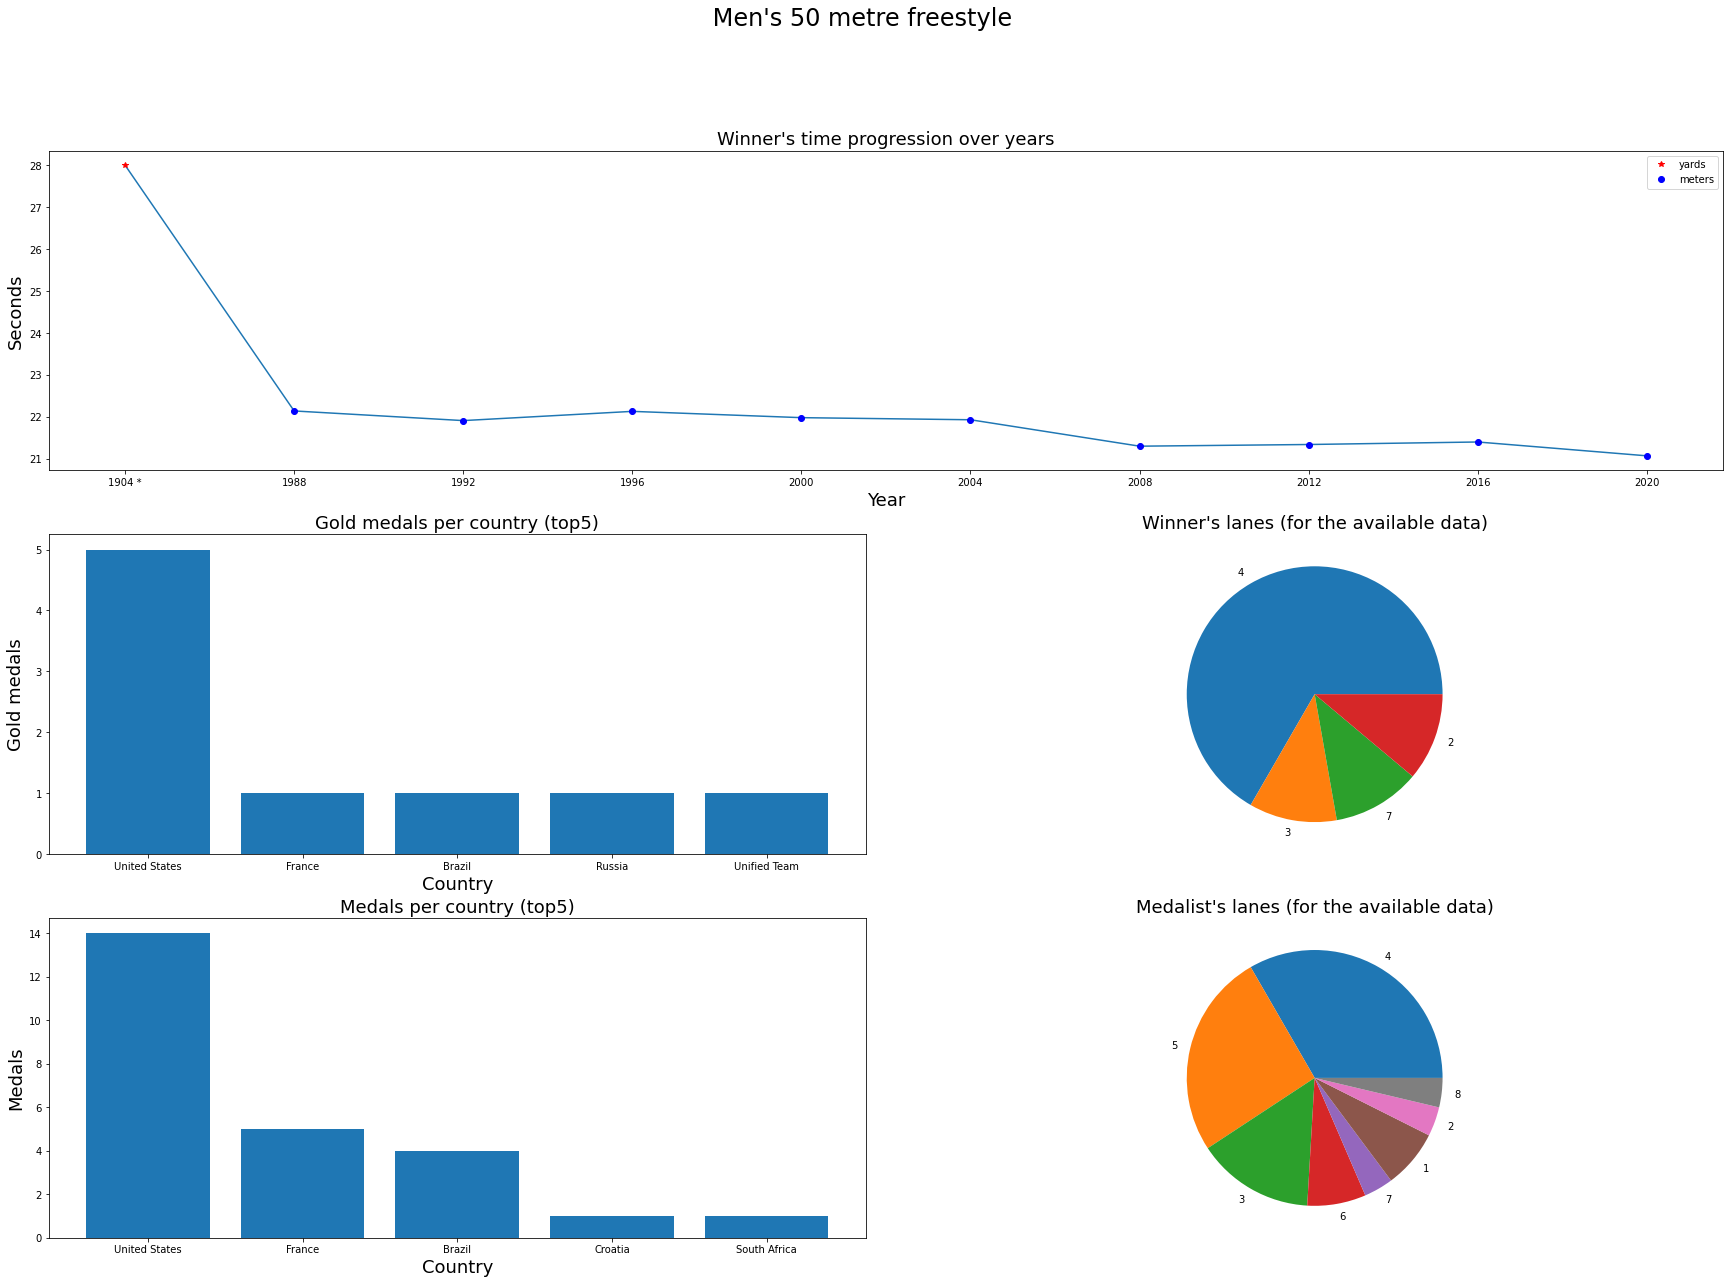

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


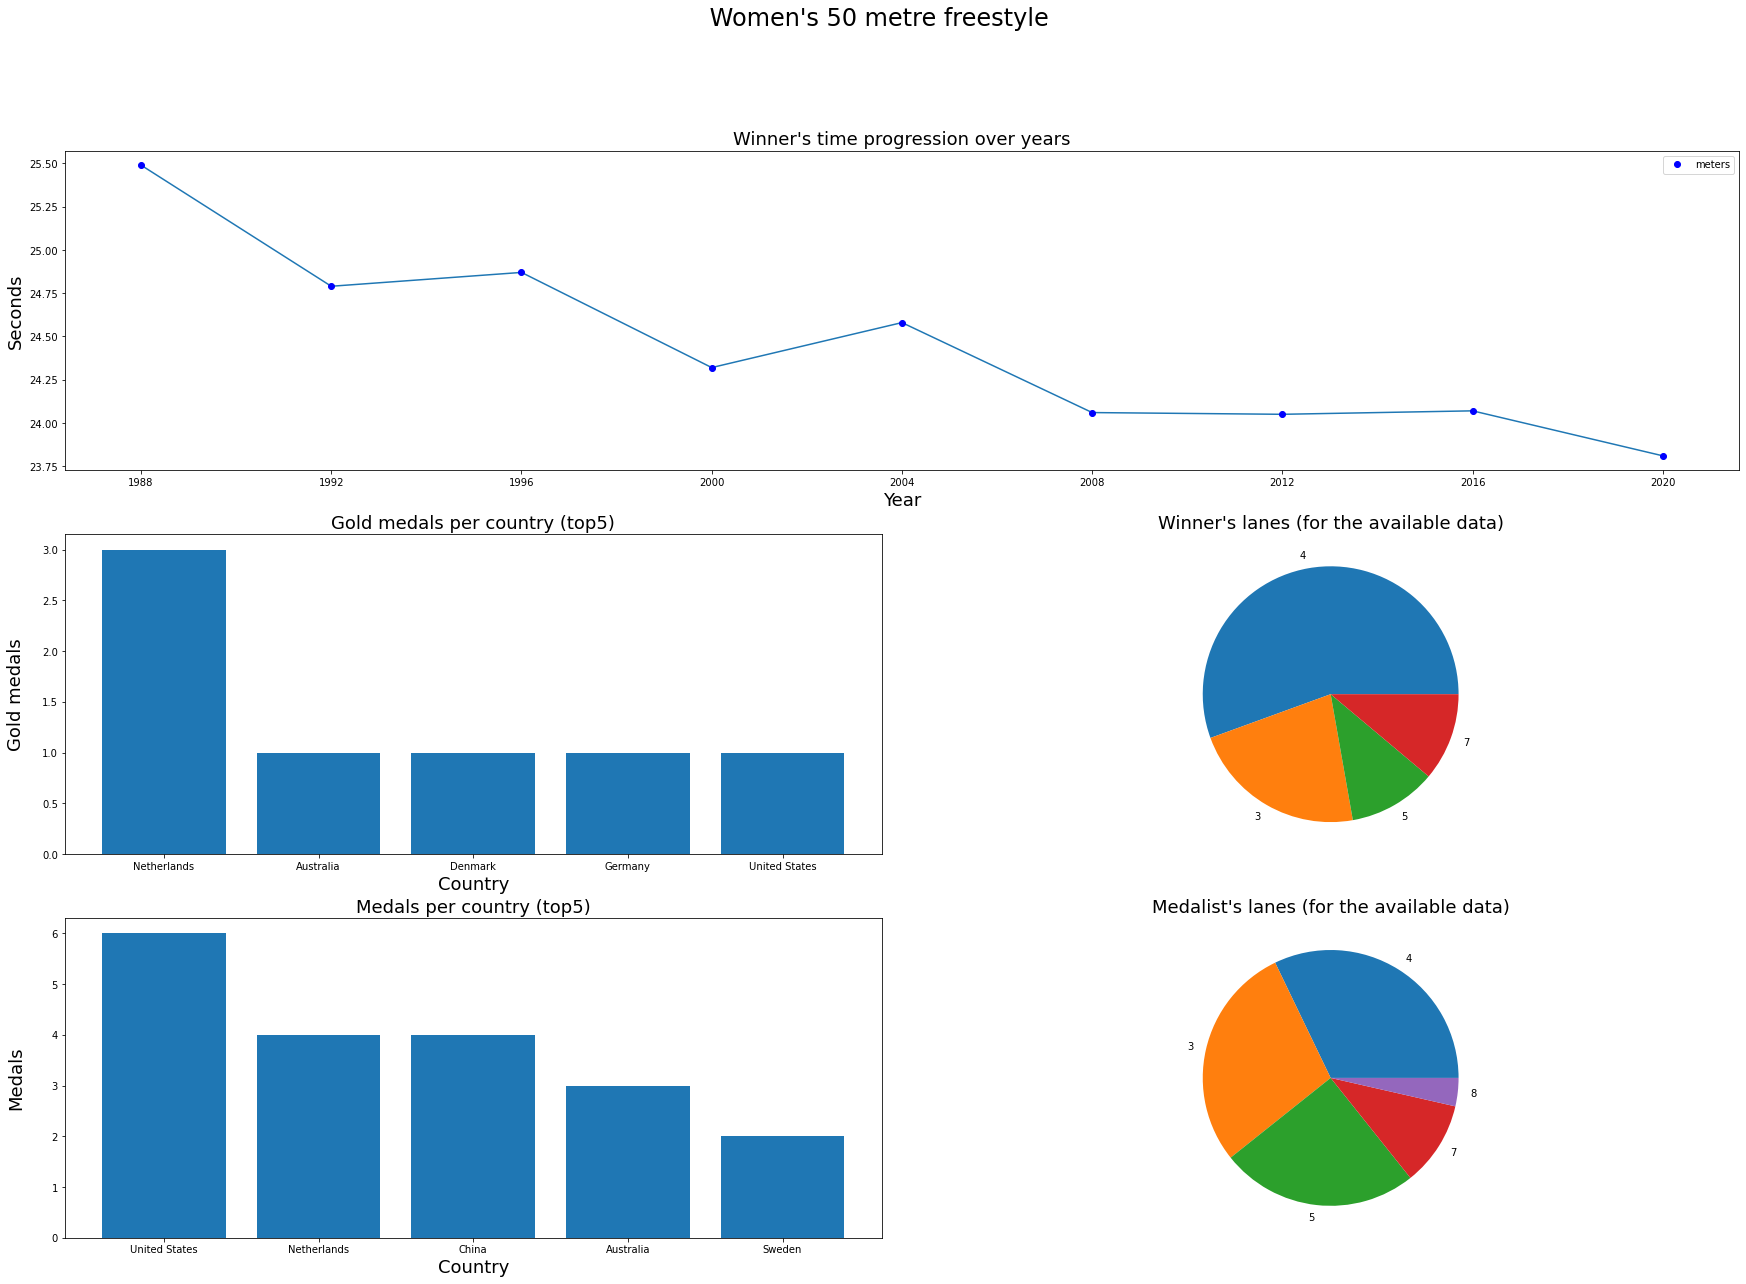

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


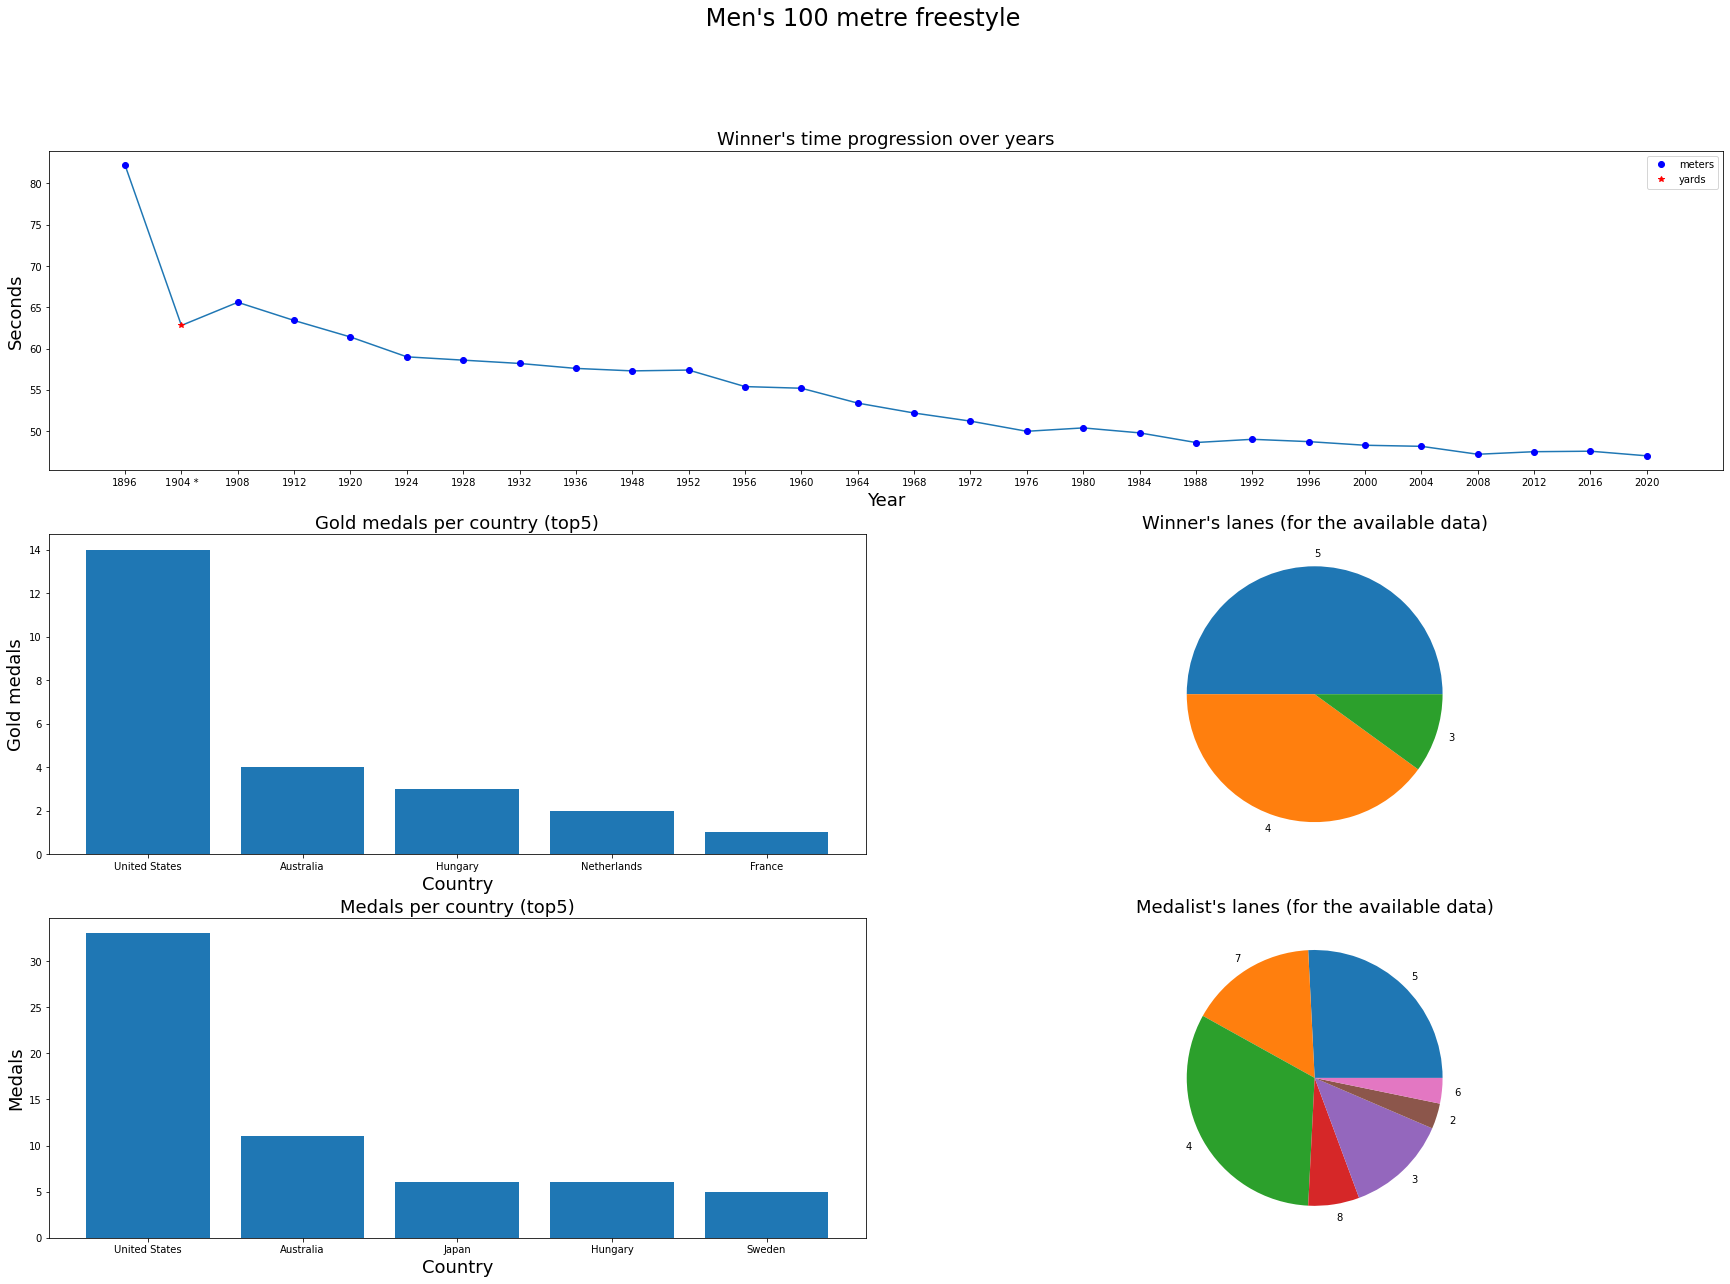

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


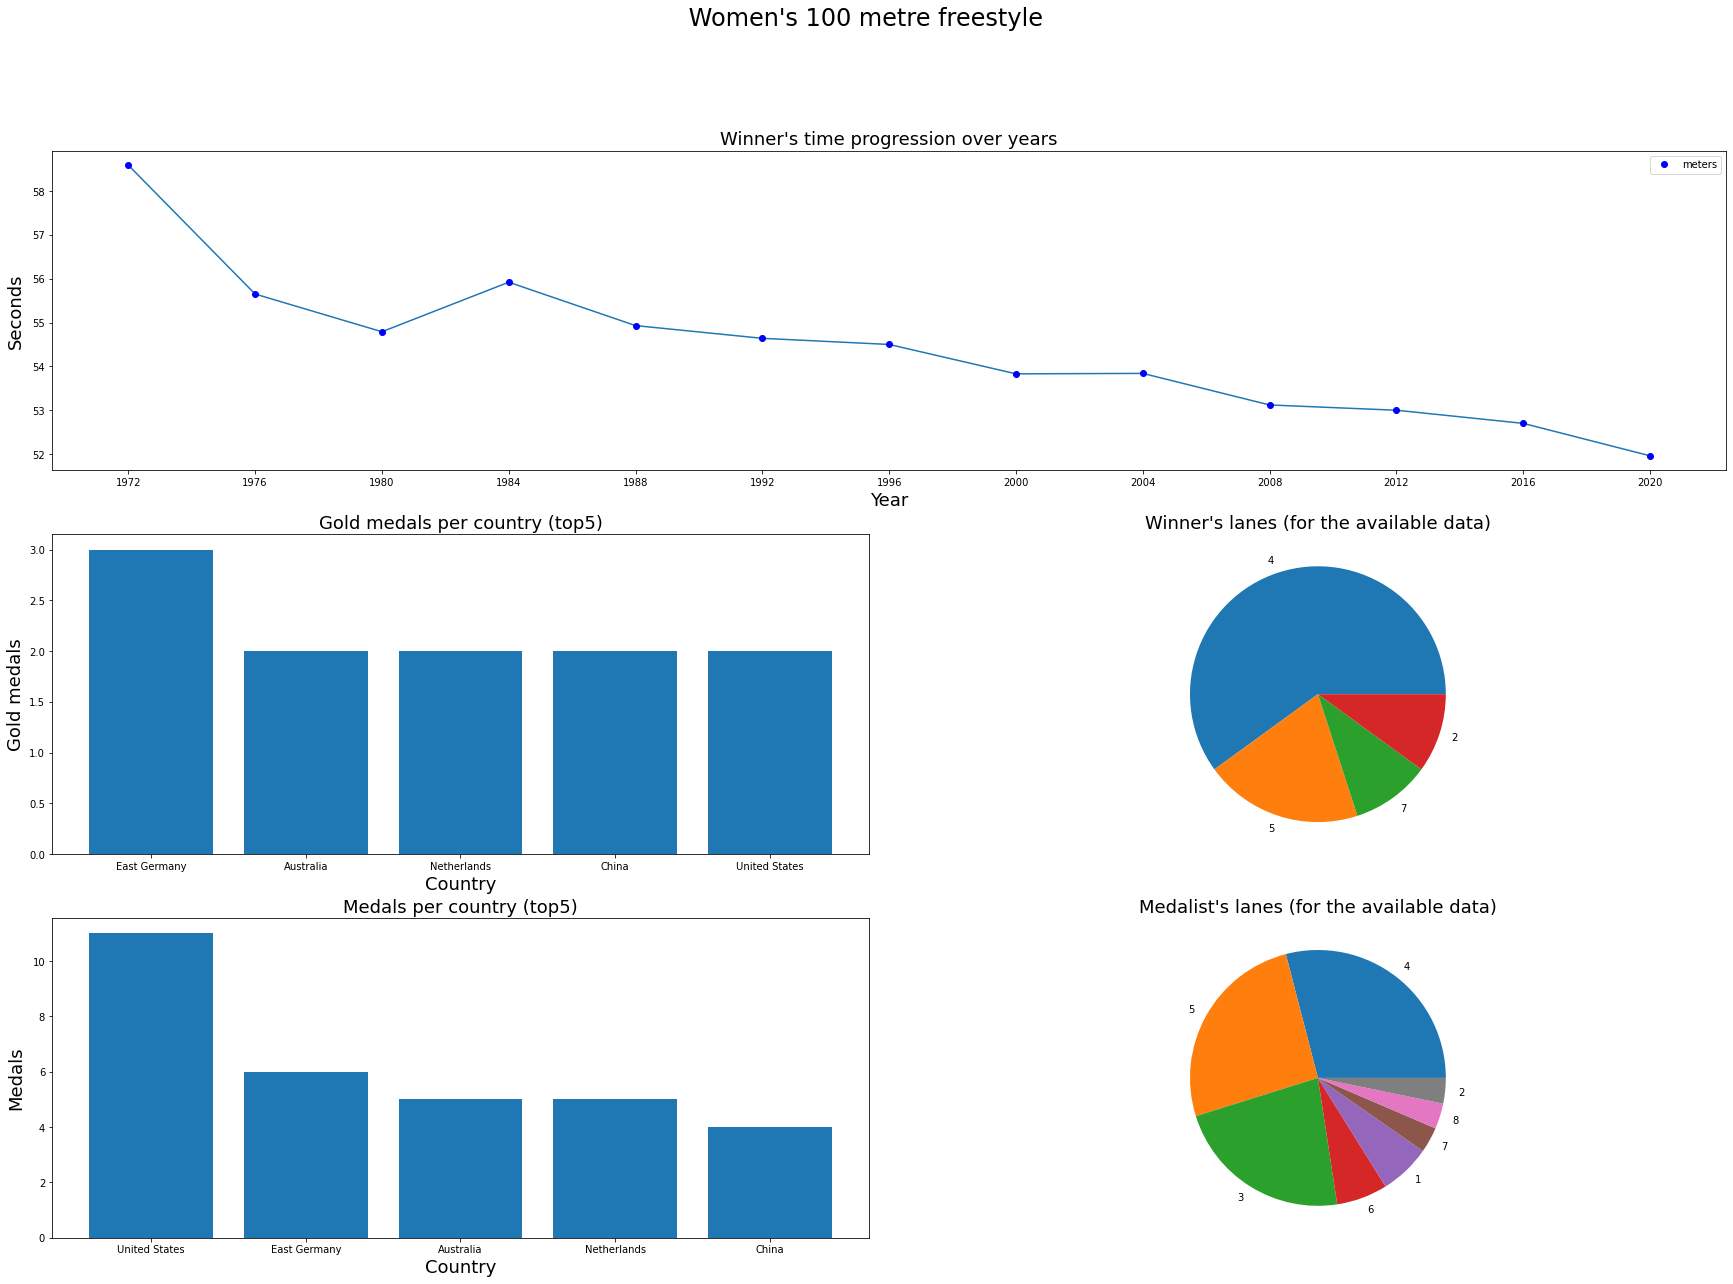

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


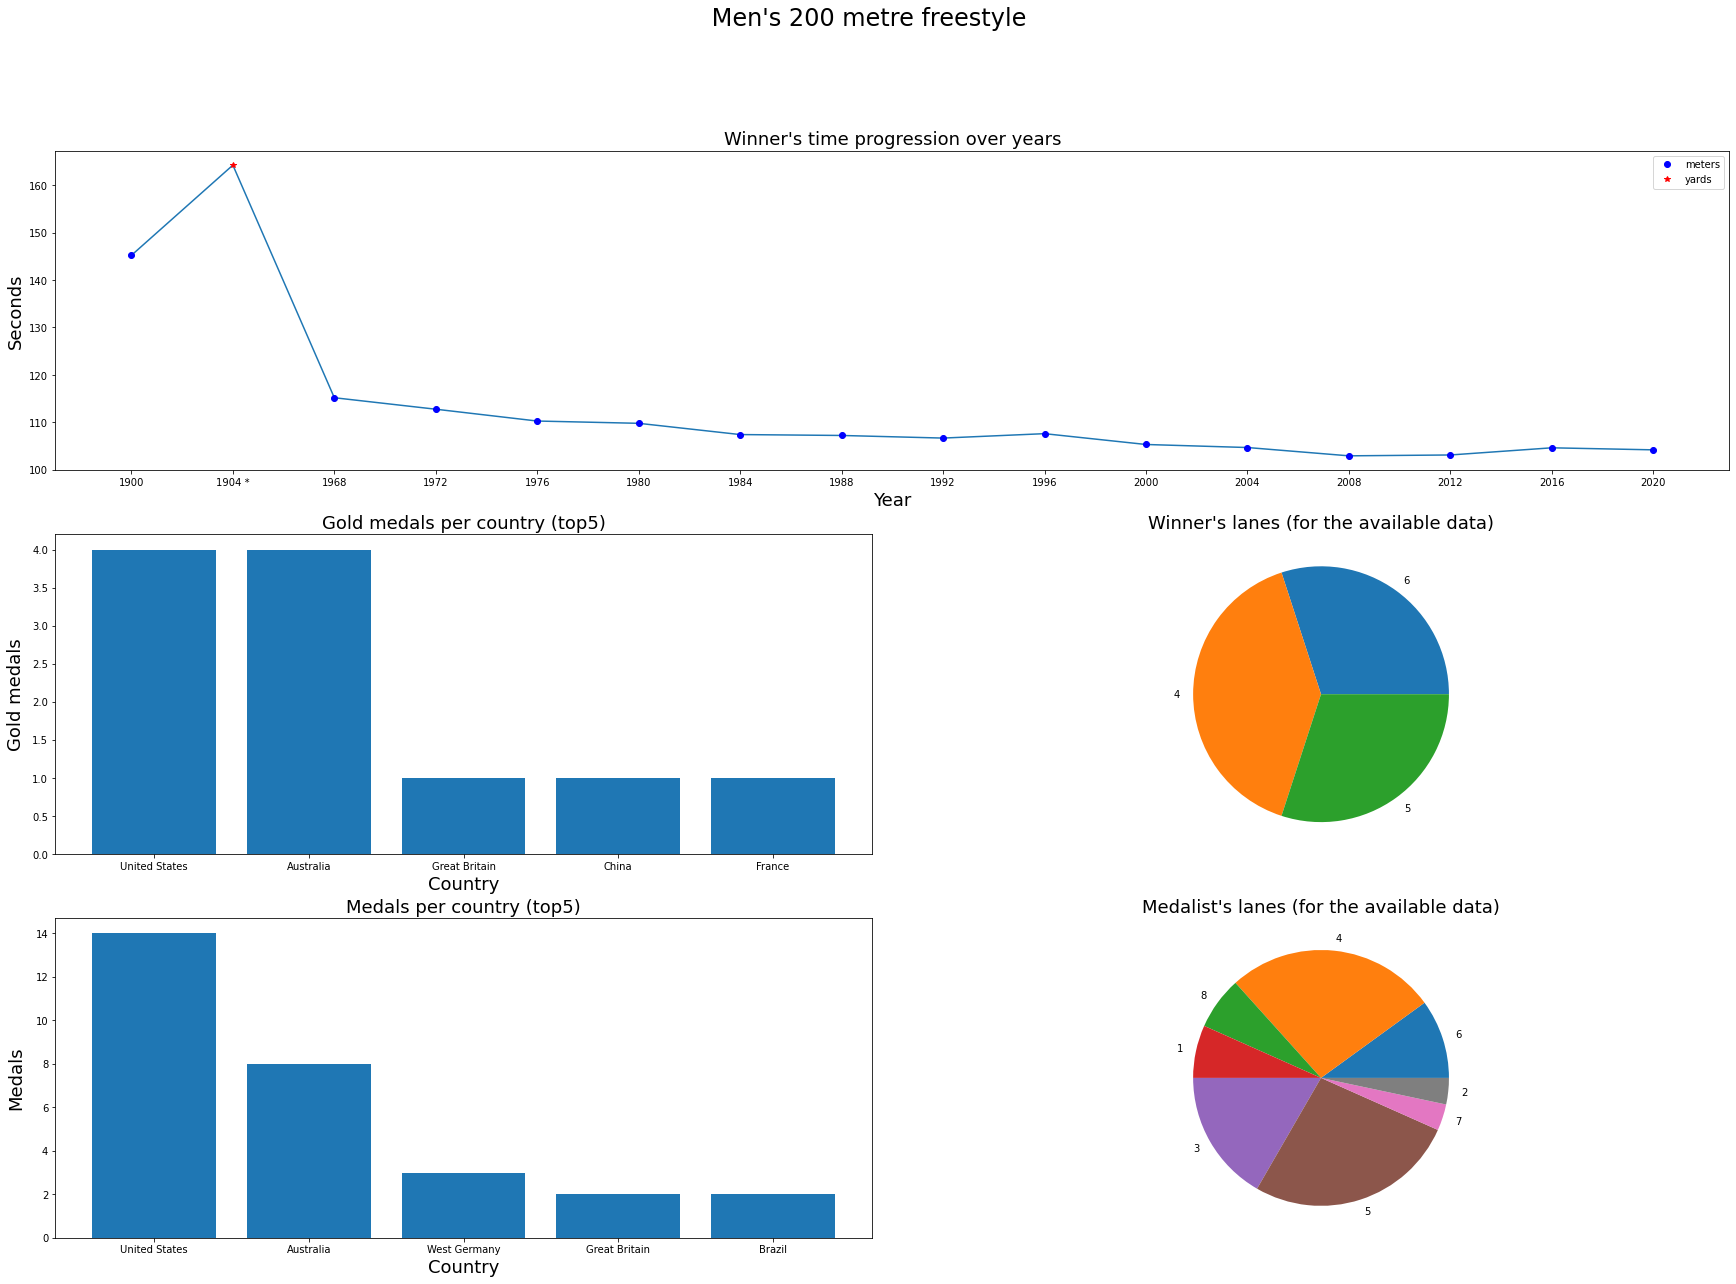

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


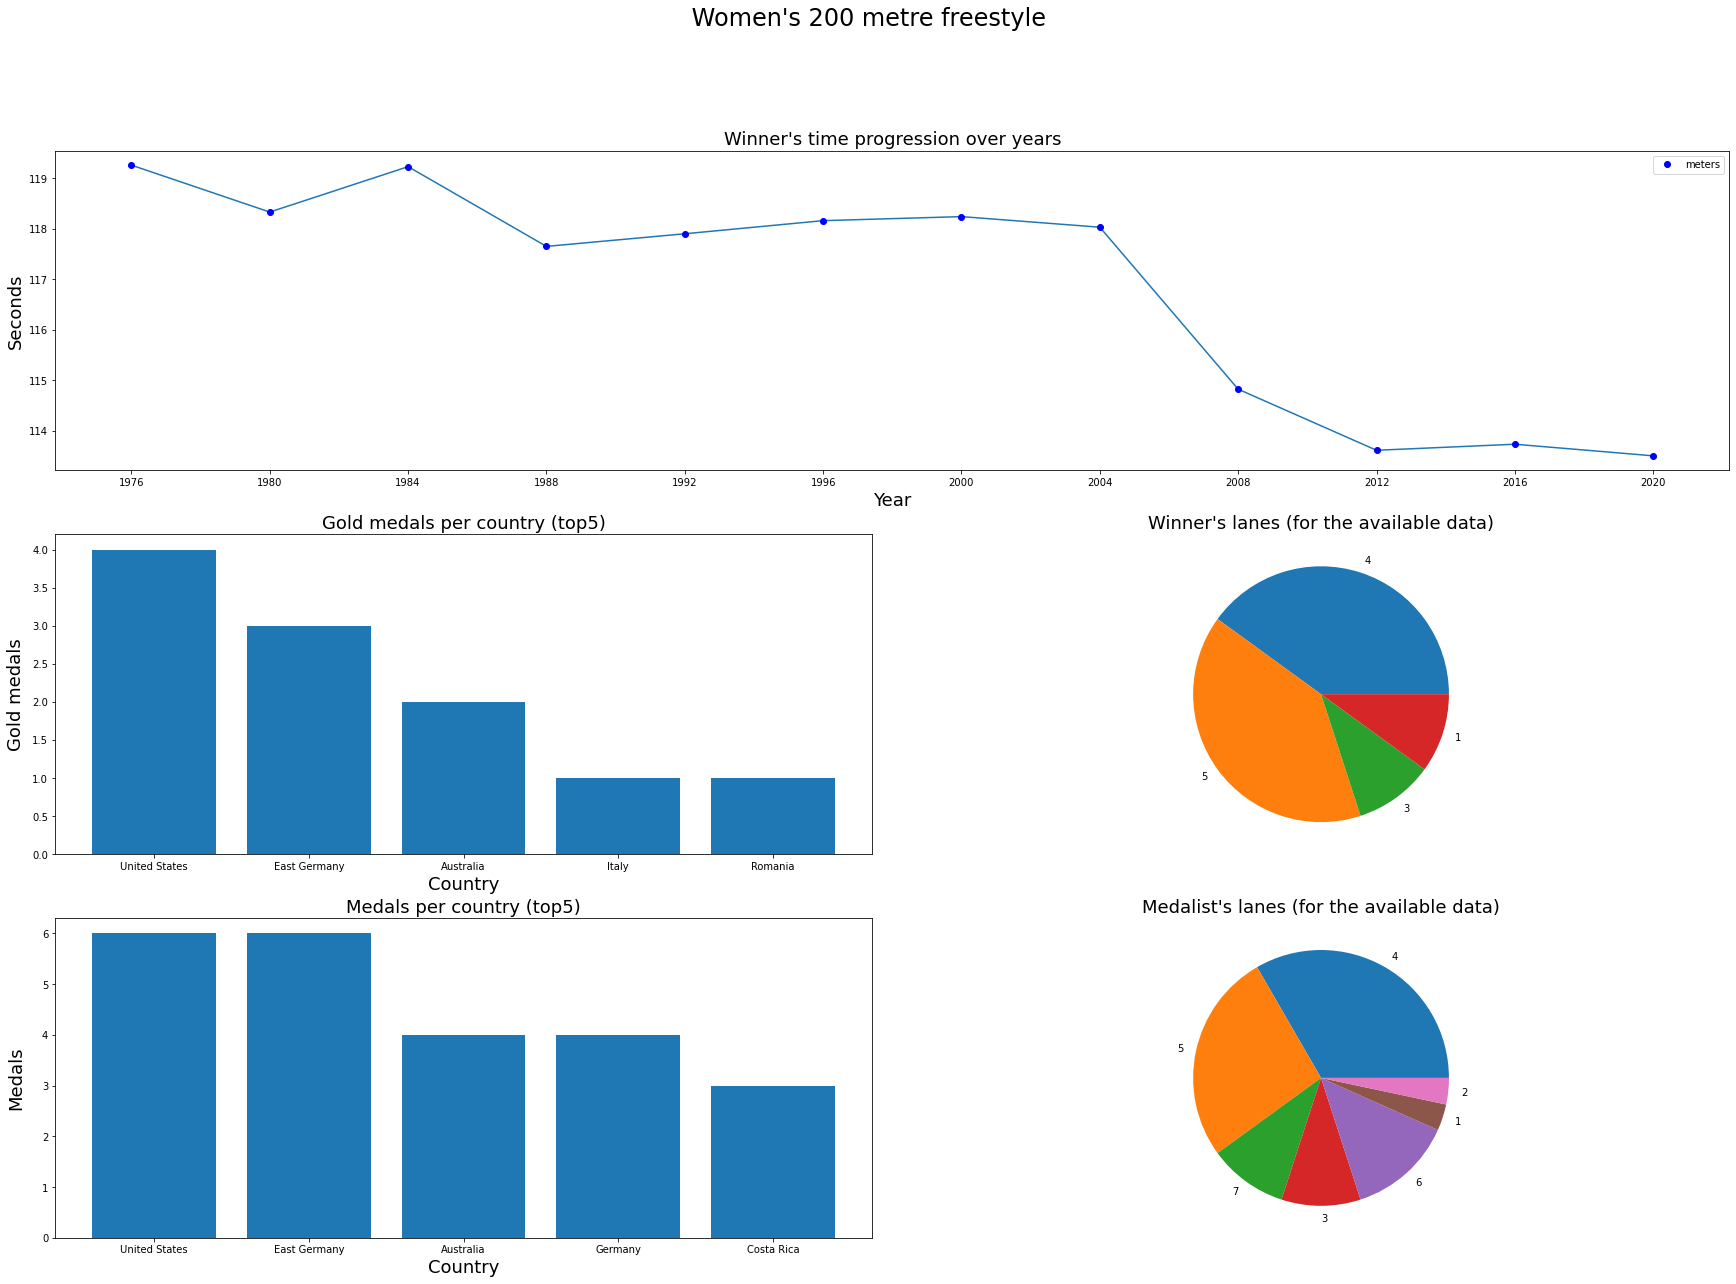

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


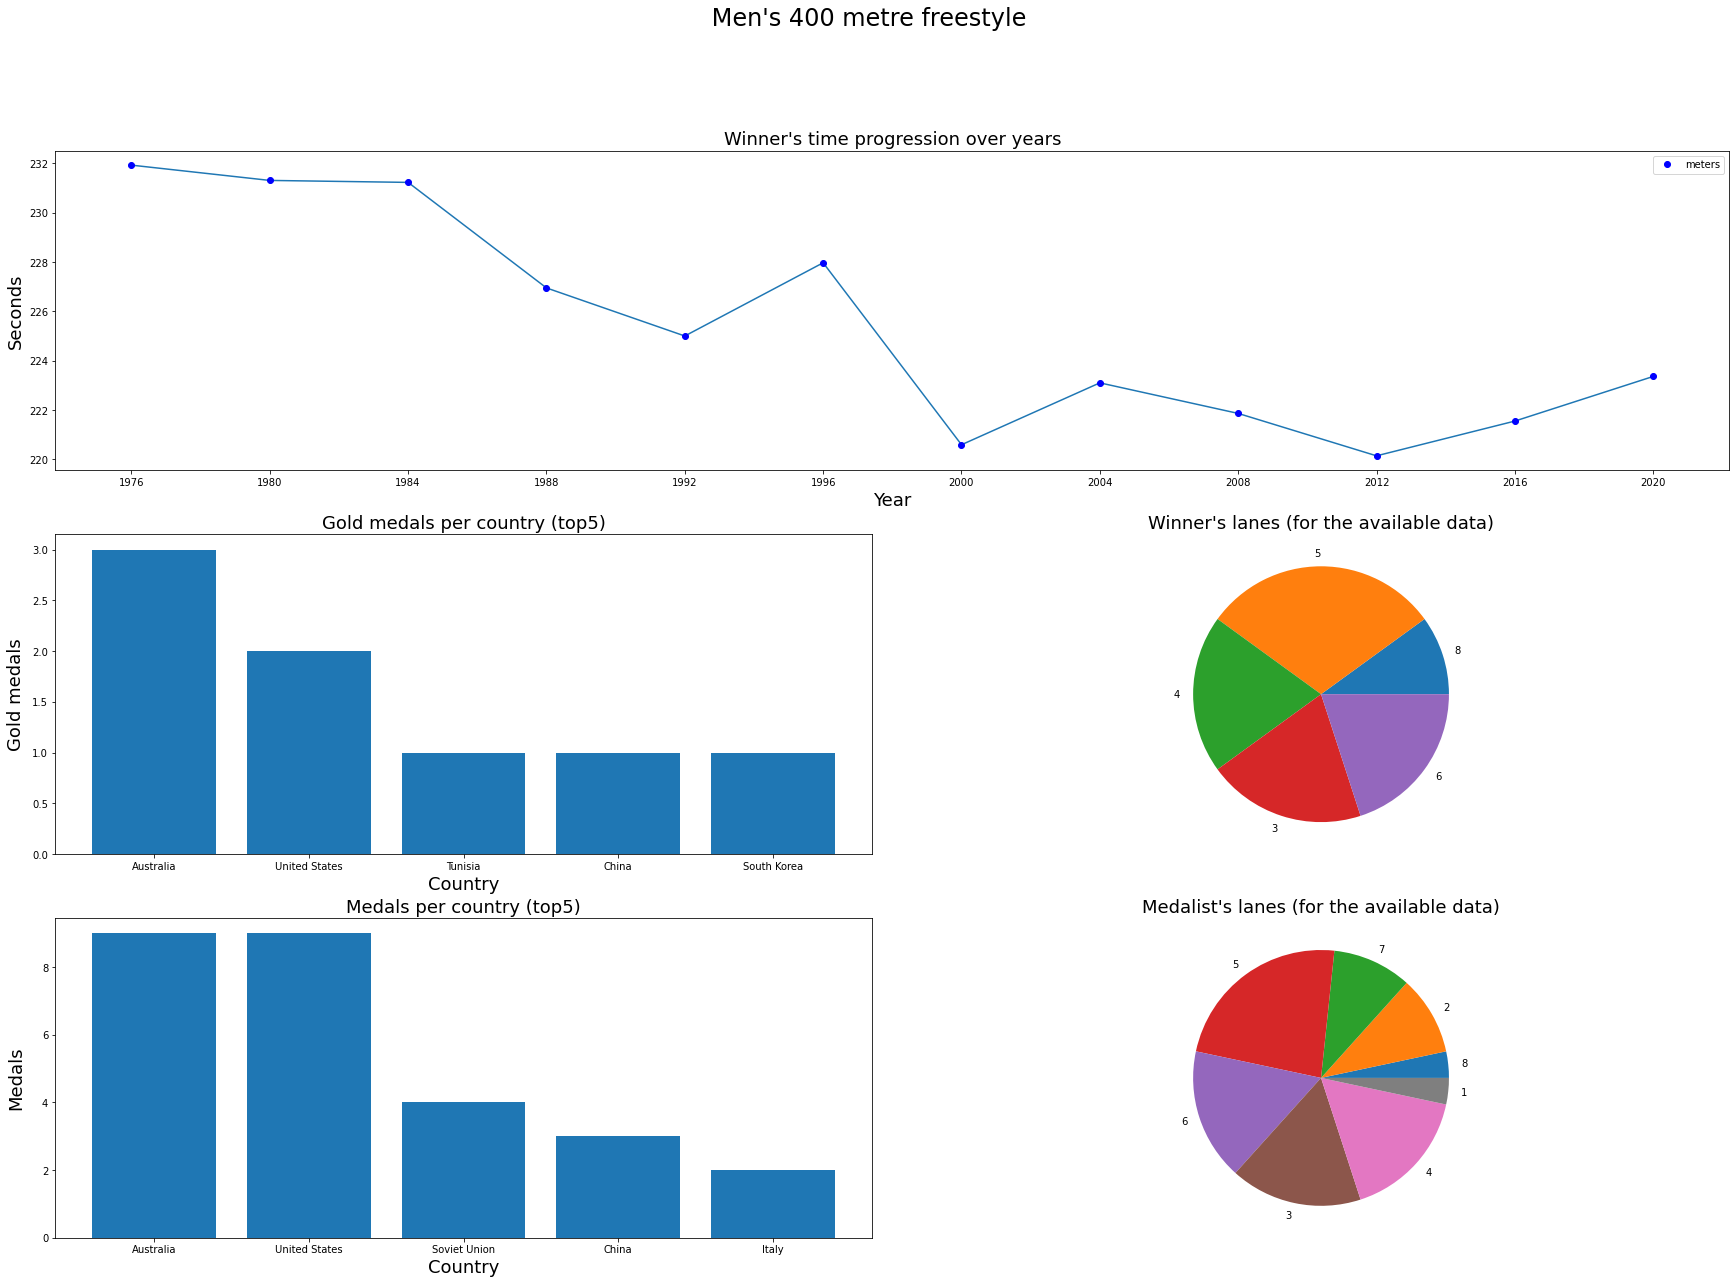

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


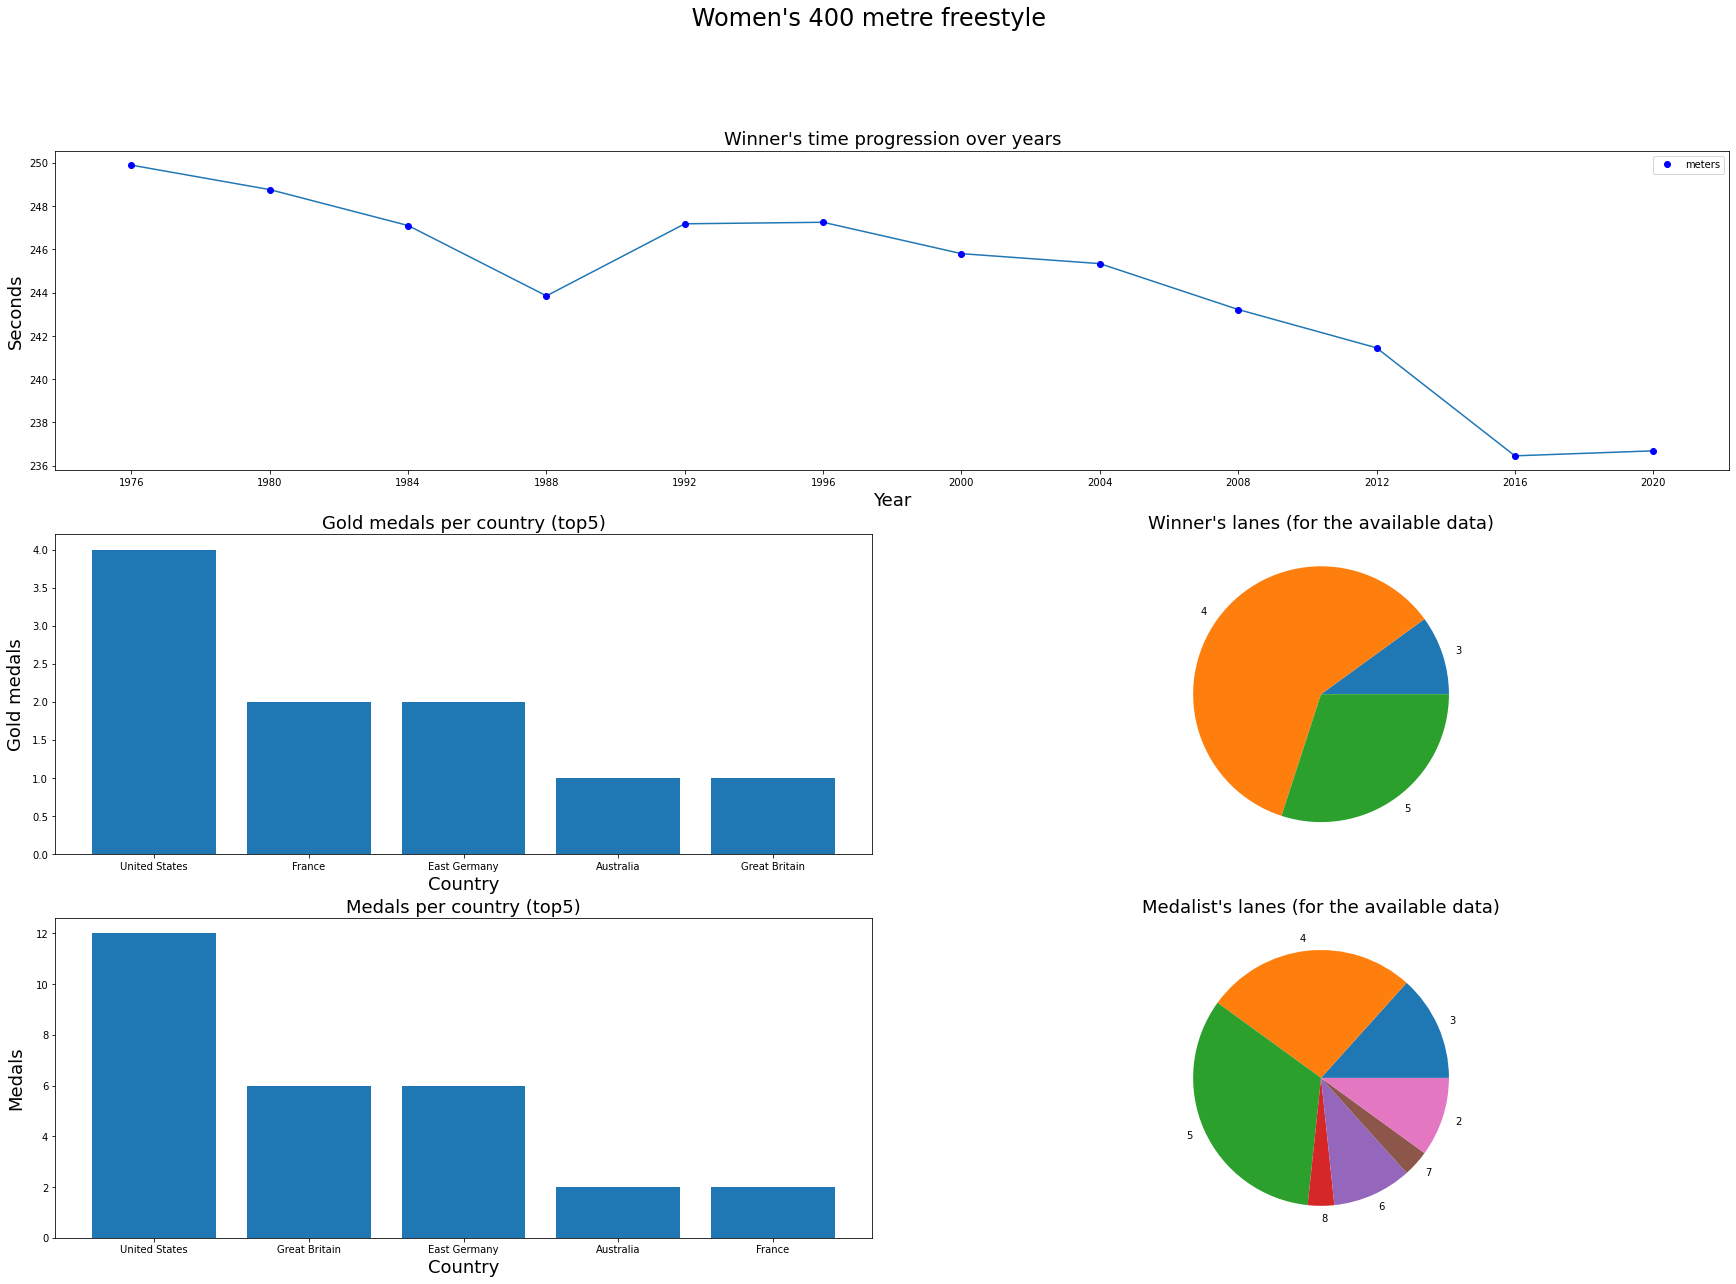

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


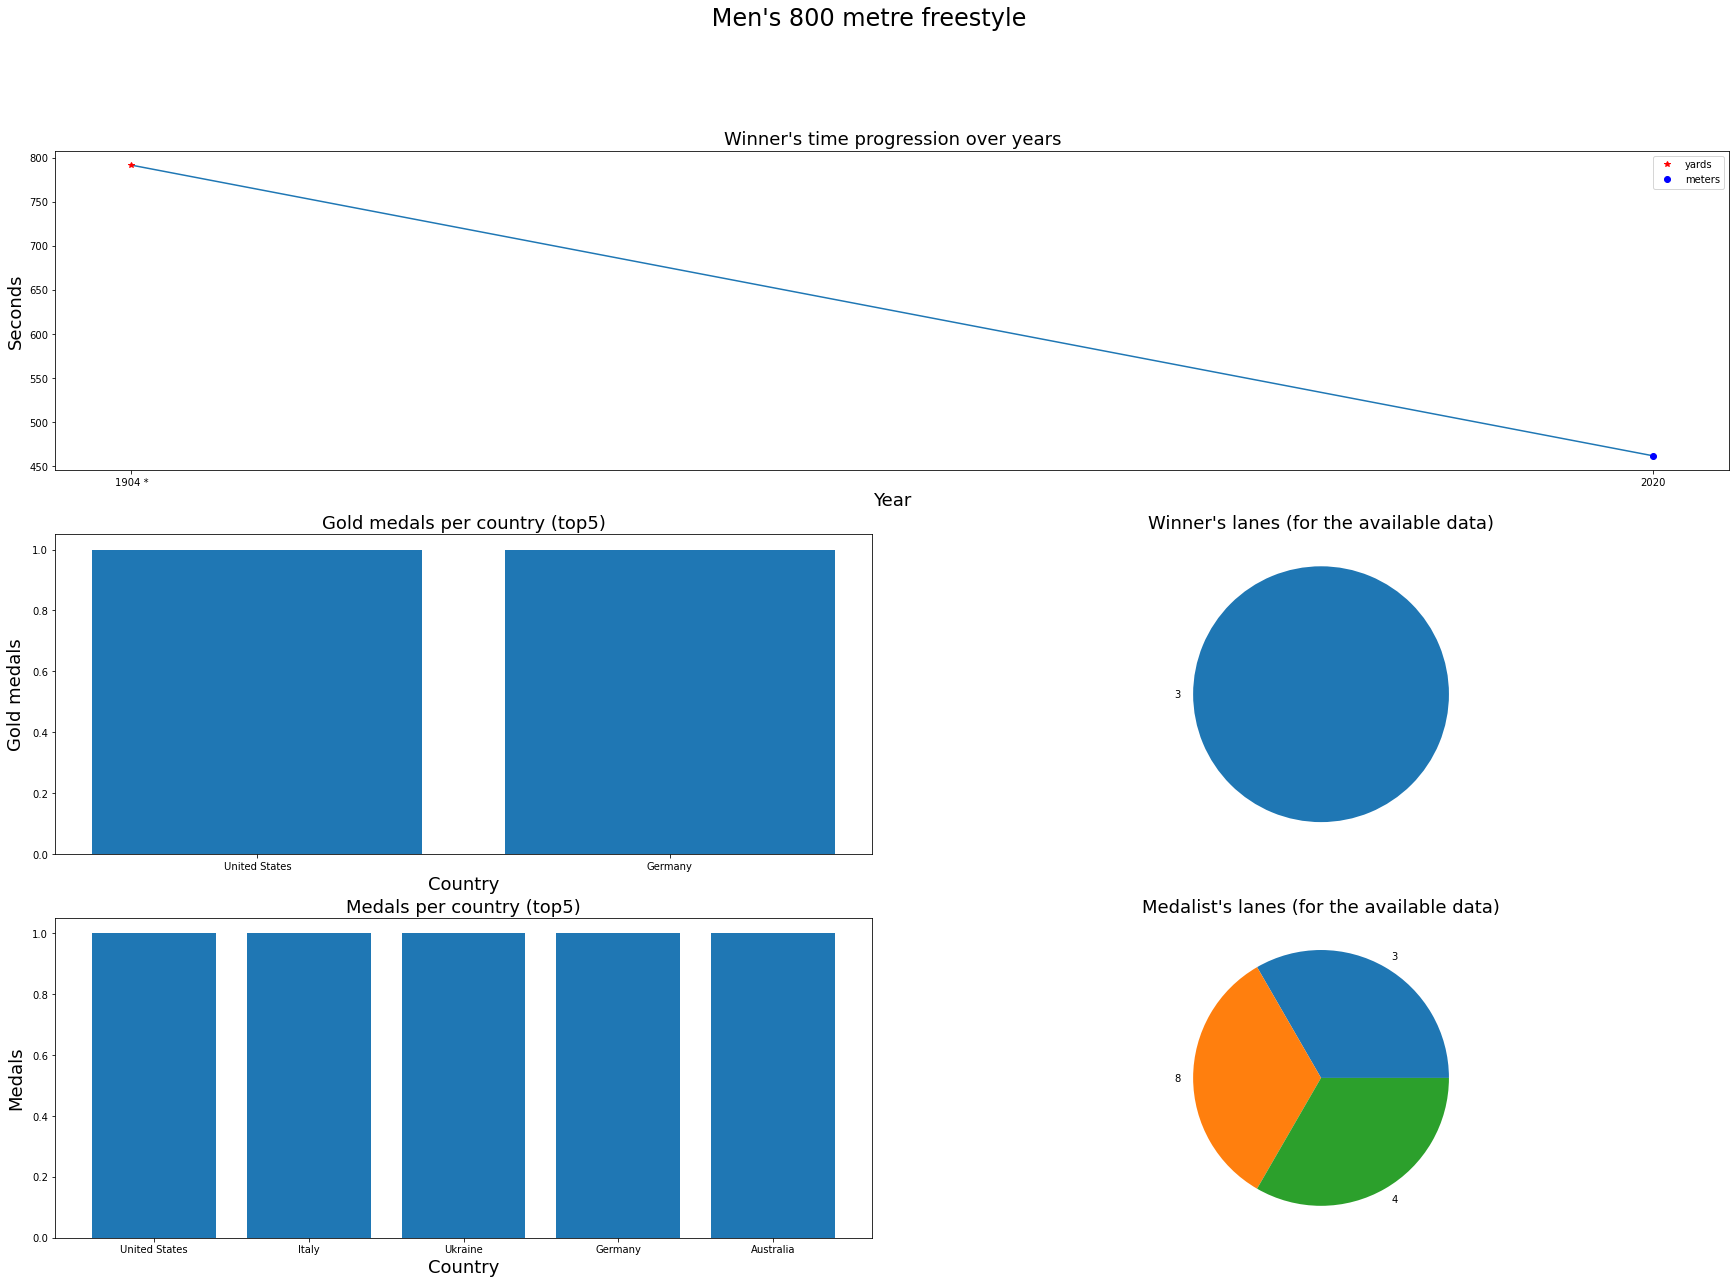

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


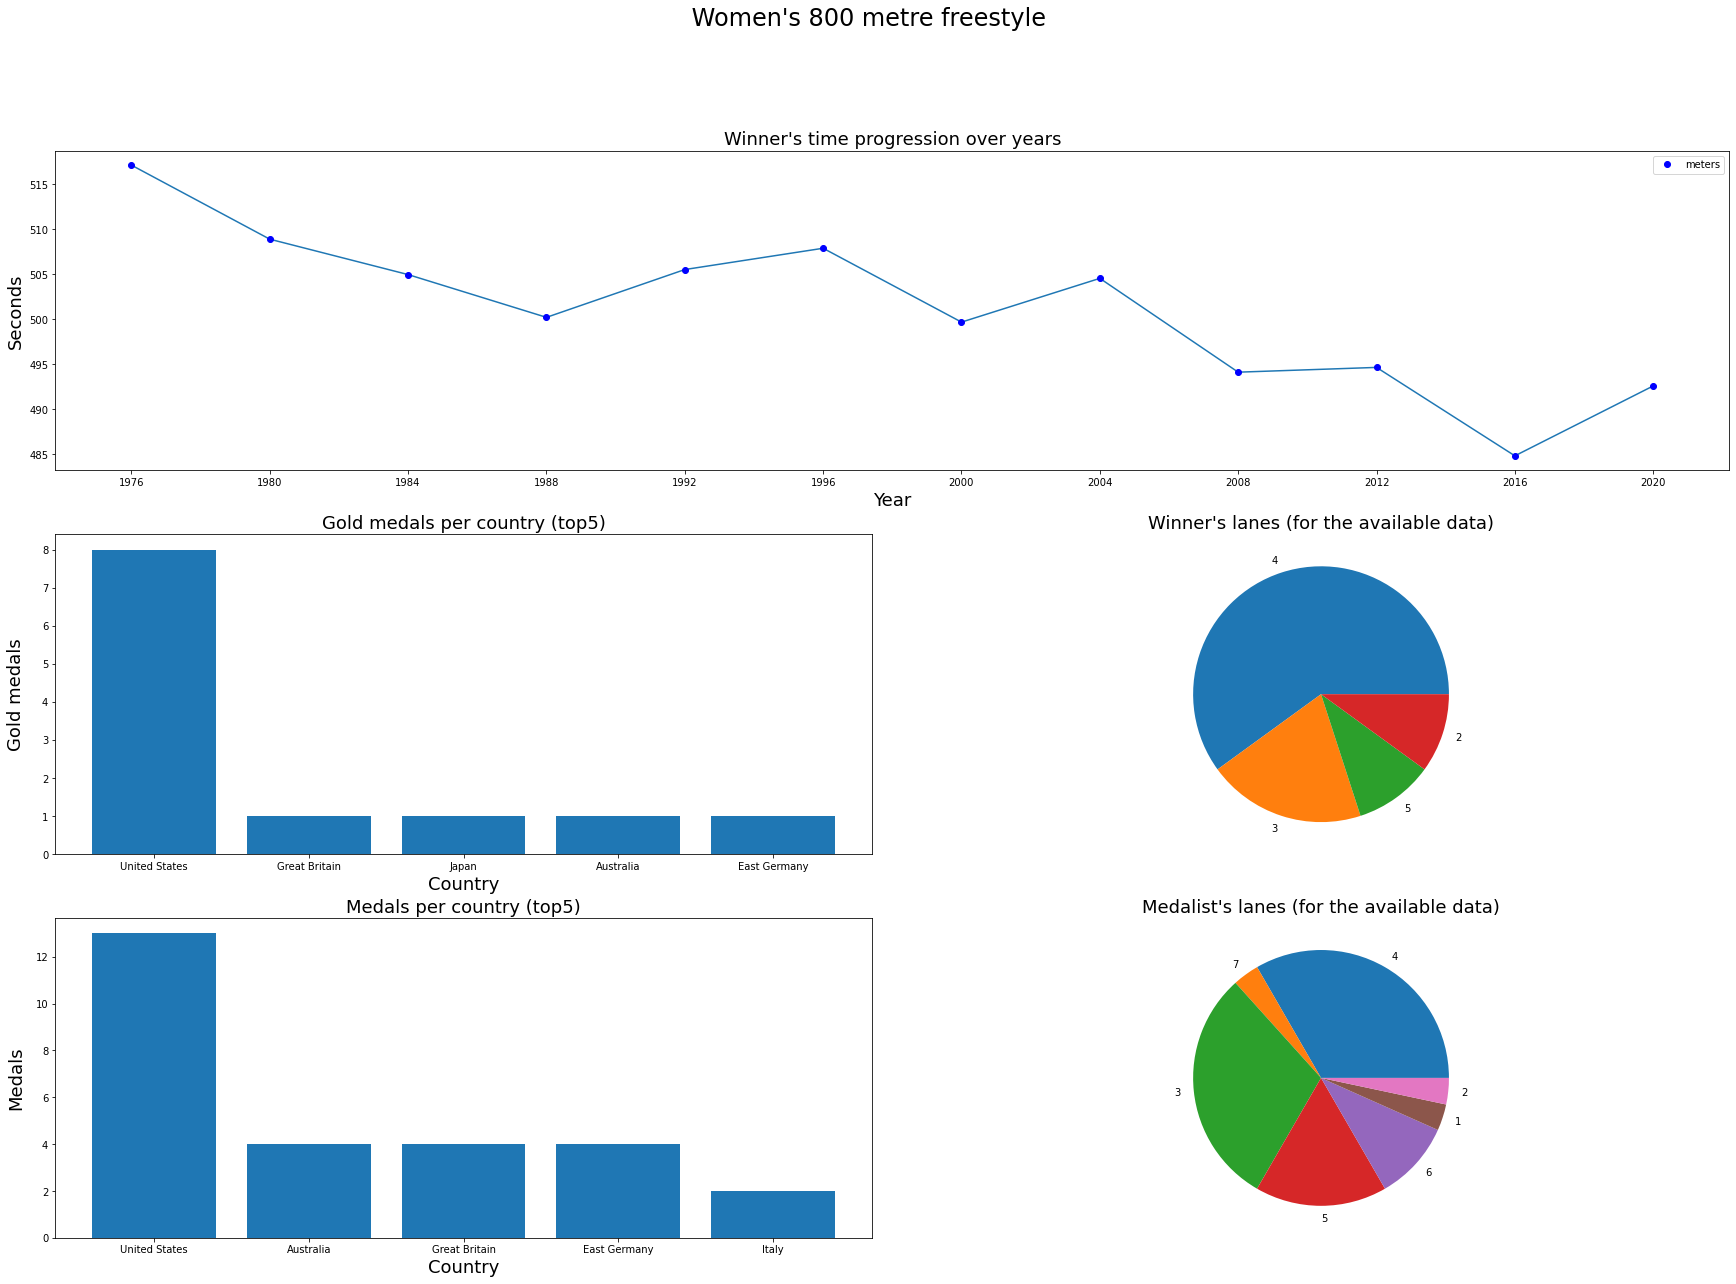

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


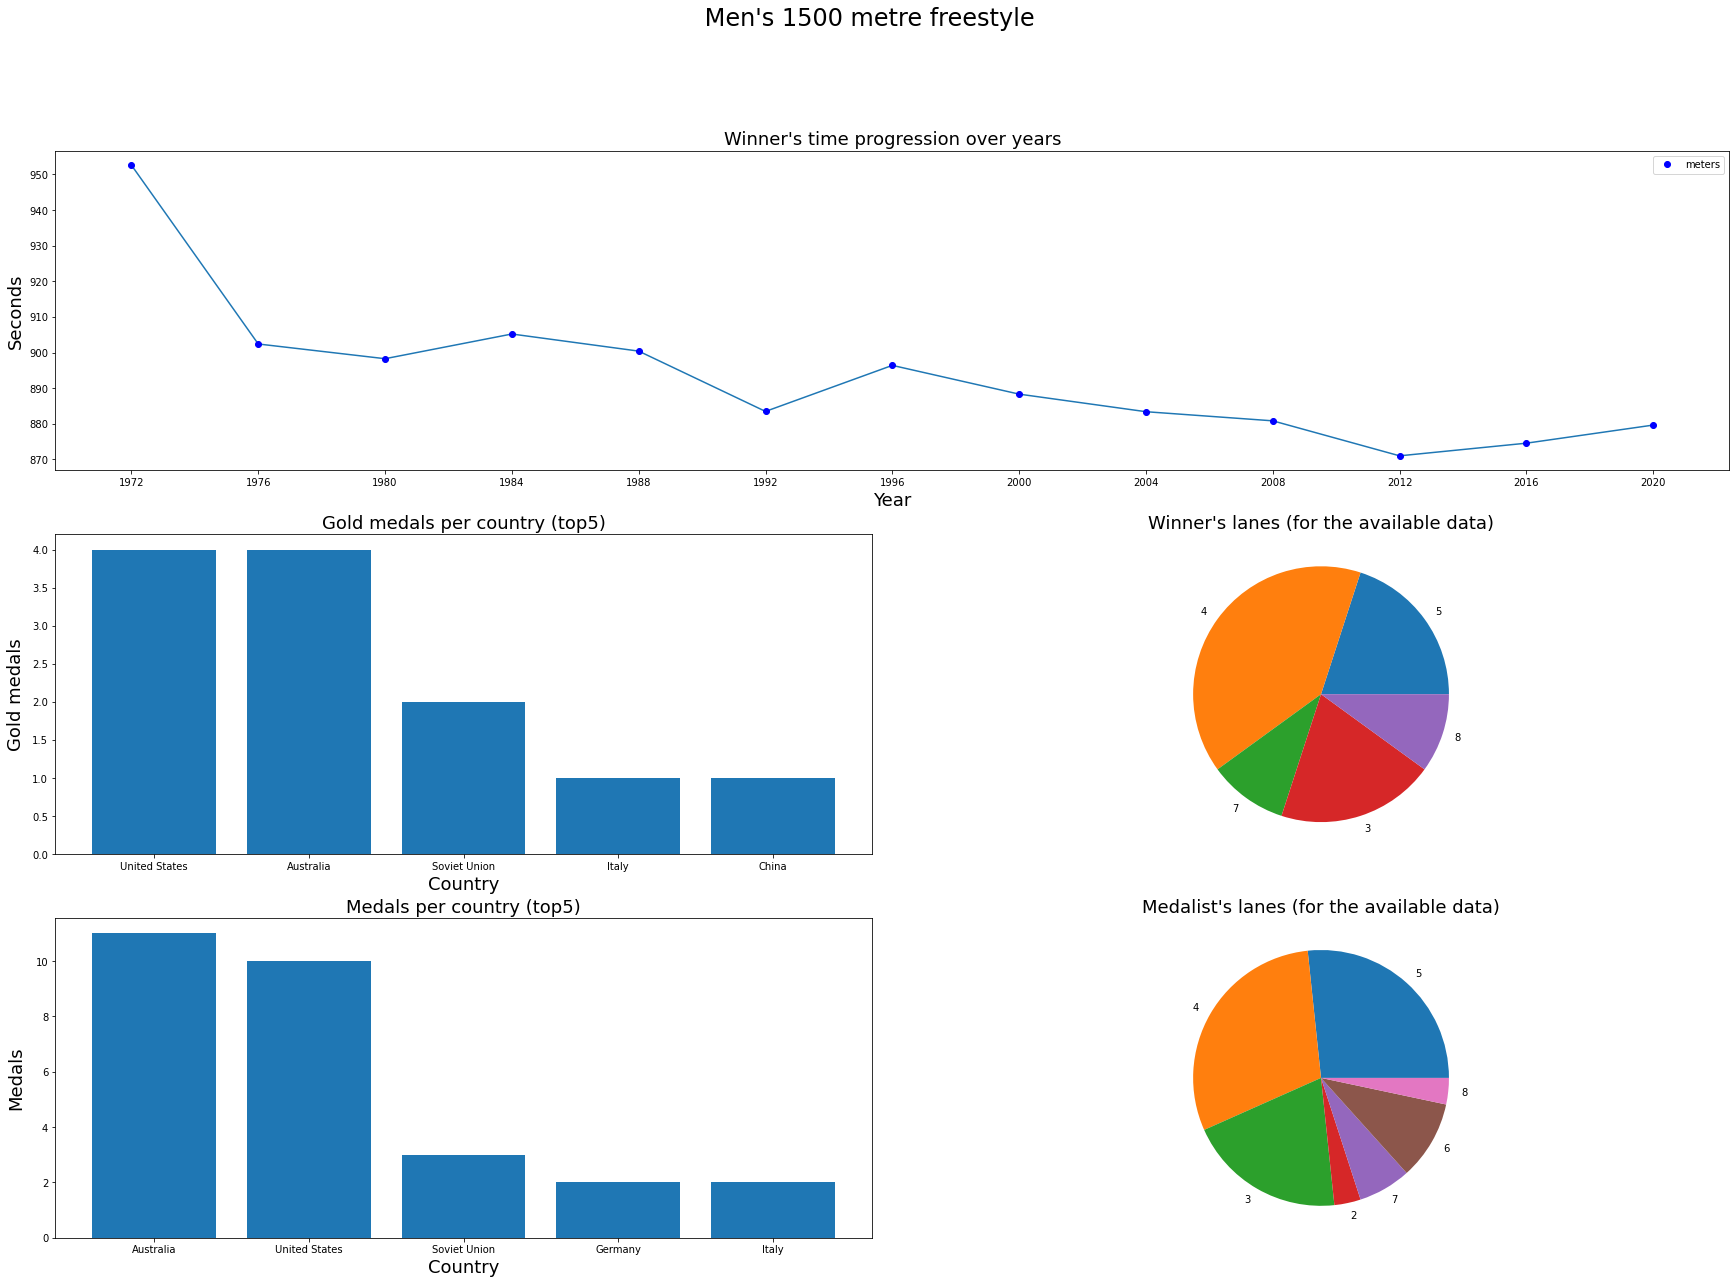

C:\Users\milos\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


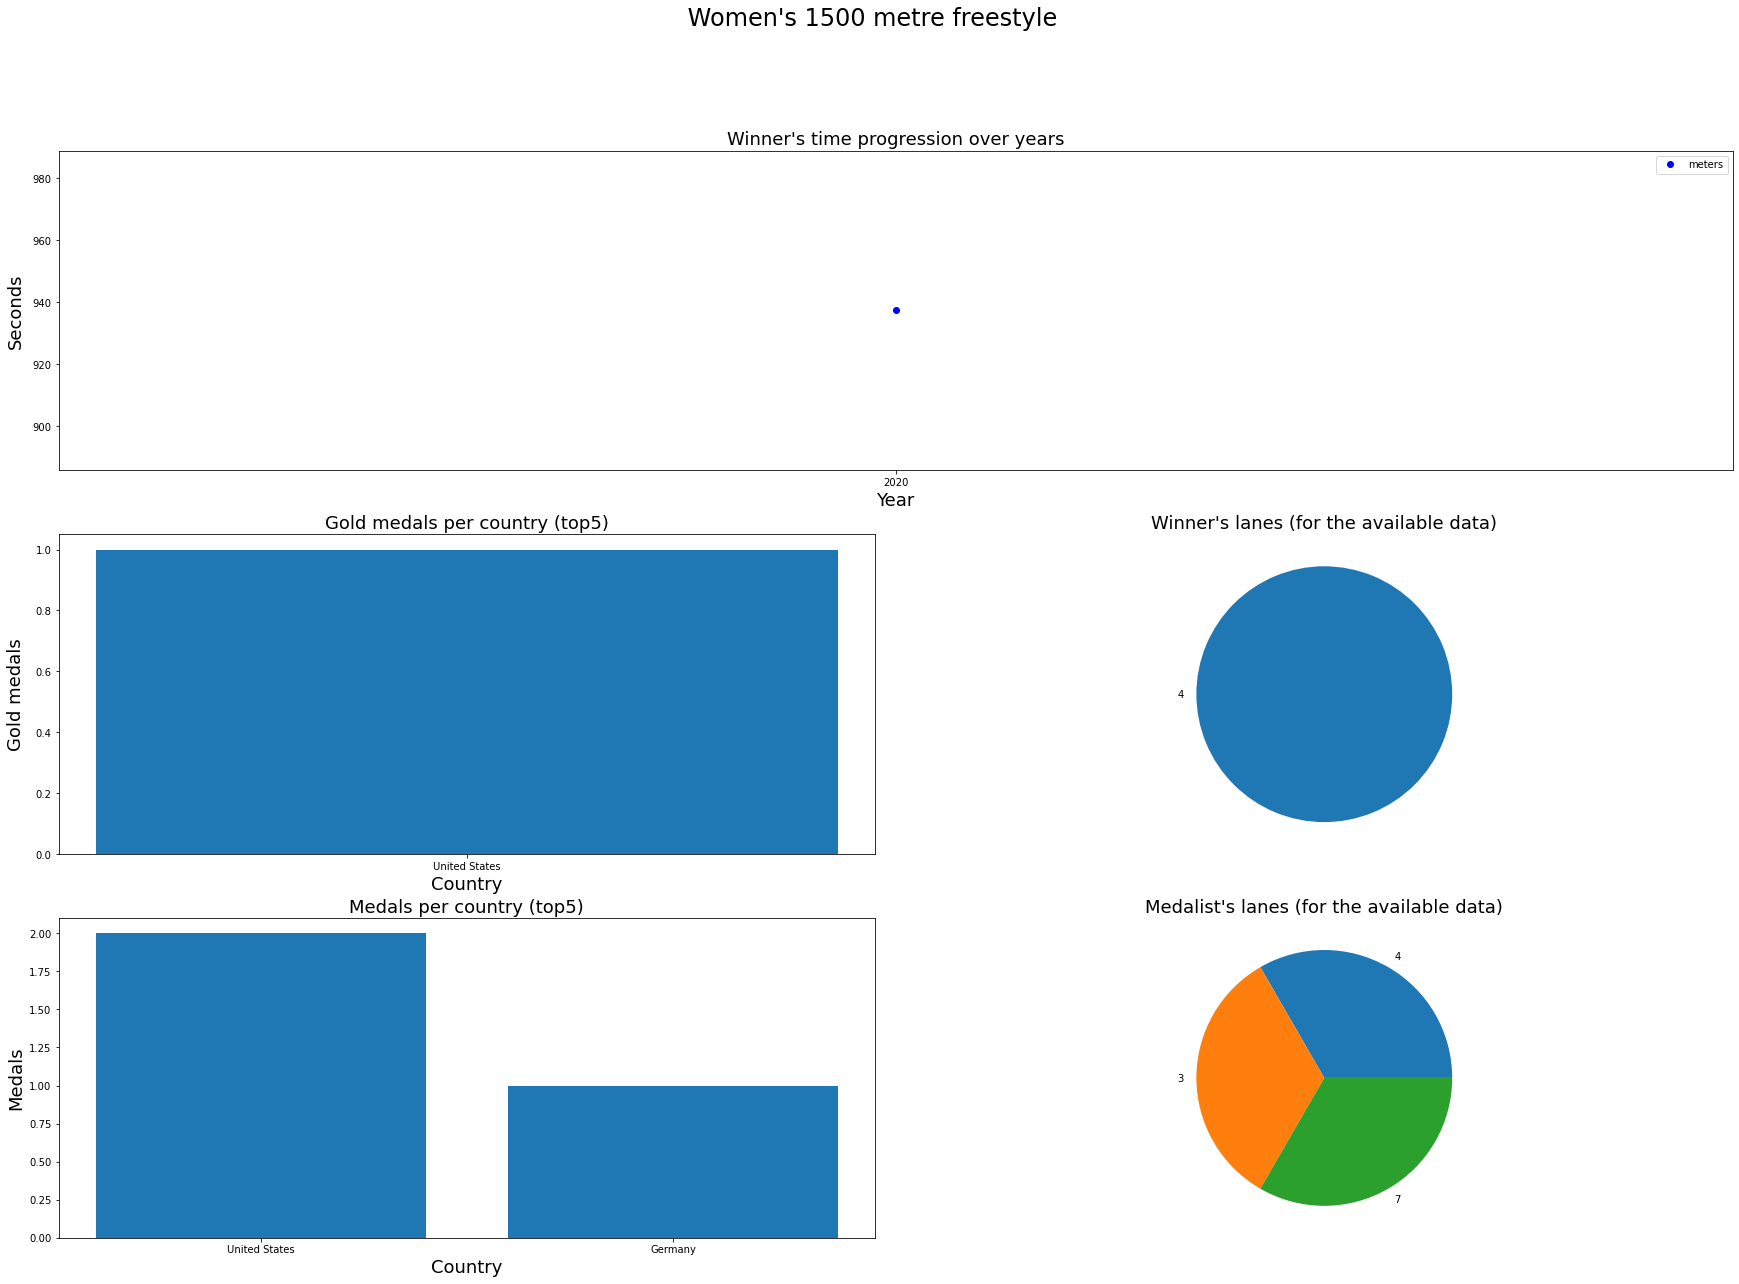

In [4]:
links = getLinks(startUrl)
#print(links)

for link in links:
    plotResults(link)
